##### Quantum Data Science 2022/2023
## Lecture 6 - Variational Classifiers *(cont)*

*Machine Learning with quantum computers -  Section 5.1.3*

## Contents

1. [VQC building blocks - Parameterized model](#ansatz)
2. [VQC building blocks - Measurement](#measurement)
      1) [Binary classification](#binary) 
      2) [Multi-class classification](#multi-class) 
3. [variational classifier for the ad_hoc dataset](#ad_hoc)
4. [Gradient-based optimization using quantum hardware](#param-shift)

##### Recall our quantum machine learning building blocks and loop!

<p align="center">
  <img width="650" height="300" src="images/loop.png">
</p>

In [4]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, execute, transpile
from qiskit.circuit import Parameter,ParameterVector
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np

In [5]:
def Embedding(x=None, n_qubits=1):

    qc = QuantumCircuit(n_qubits,name="S")

    if x is not None:
        ### TO DO ###
        pass

    return qc

def Ansatz(theta=None, n_qubits=1):

    qc = QuantumCircuit(n_qubits,name="U($\theta$)")

    if theta is not None:
        ### TO DO ###
        pass
    
    return qc

def Measurement(qc, n_qubits=1):

    qc.measure_all()
    ### change me at your will ###
    
    return qc

Empty example

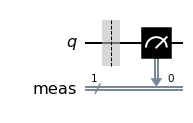

In [6]:
x = Parameter("x")
theta = Parameter(r'$\theta$')

encoding = Embedding(x)
ansatz = Ansatz(theta)

qc = encoding.compose(ansatz)
full_qc = Measurement(qc)

full_qc.draw(output="mpl")

## 1. VQC building blocks - Parameterized model <a id="ansatz"></a>
We have seen different forms of encoding data. What about the variational form?

Enters Ansatz

Qiskit has some well known ansatze already implemented. Look at <href>[*qiskit.circuit.library*](https://qiskit.org/documentation/apidoc/circuit_library.html)</href>. You can build most of your own Ansatze starting from these.


#### **TwoLocal**
The two-local circuit is a parameterized circuit consisting of alternating rotation layers and entanglement layers. The rotation layers are single qubit gates applied on all qubits

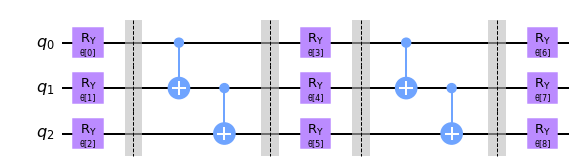

In [7]:
from qiskit.circuit.library import TwoLocal

#(num_qubits=None, rotation_blocks=None, entanglement_blocks=None, entanglement='full', reps=3, skip_unentangled_qubits=False, 
#   skip_final_rotation_layer=False, parameter_prefix='θ', insert_barriers=False, initial_state=None, name='TwoLocal')

TwoLocal(3, rotation_blocks='ry', entanglement_blocks='cx', entanglement='linear', reps=2, insert_barriers=True).decompose().draw(output="mpl")

**skip_final_rotation_layer** - If true removes a last varational layer that has no entanglement - works as a change of basis 

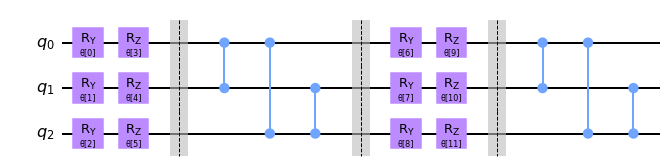

In [34]:
TwoLocal(3, ['ry','rz'], entanglement_blocks='cz', entanglement='full', reps=2, insert_barriers=True,skip_final_rotation_layer=True).decompose().draw(output="mpl")


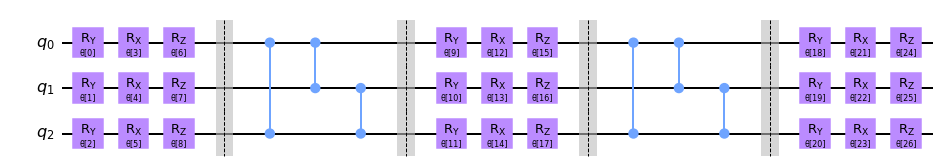

In [8]:
TwoLocal(3, ['ry','rx','rz'], 'cz', 'circular', reps=2, insert_barriers=True).decompose().draw(output="mpl")


#### **RealAmplitudes** 

The RealAmplitudes circuit is a heuristic trial wave function used as Ansatz in chemistry applications or classification circuits in machine learning. The circuit consists of of alternating layers of 𝑌 rotations and 𝐶𝑋 entanglements. The entanglement pattern can be user-defined or selected from a predefined set

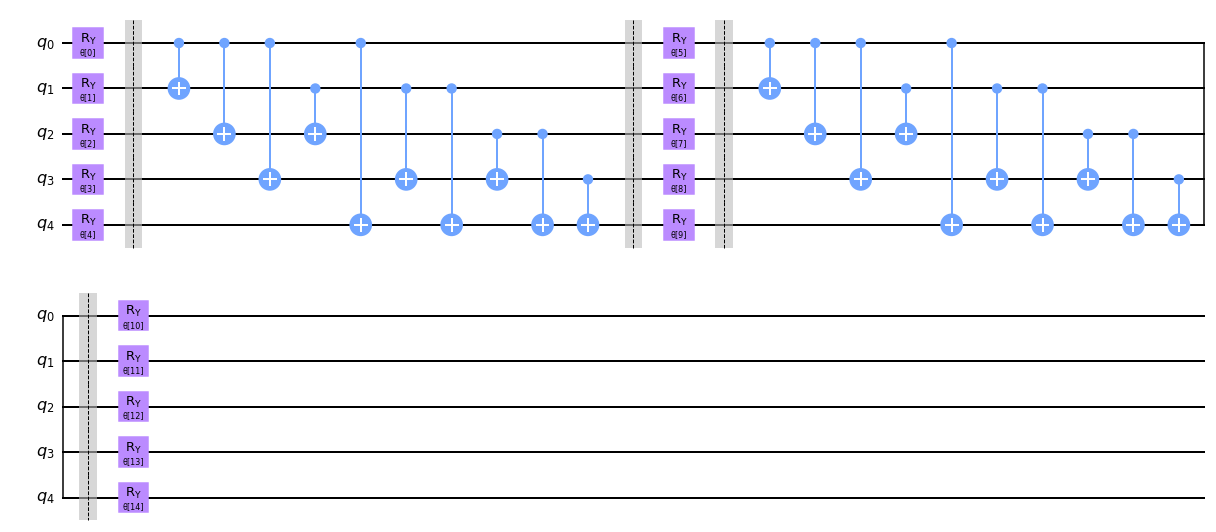

In [61]:
from qiskit.circuit.library import RealAmplitudes

#(num_qubits=None, entanglement='full', reps=3, skip_unentangled_qubits=False, skip_final_rotation_layer=False, 
#   parameter_prefix='θ', insert_barriers=False, initial_state=None, name='RealAmplitudes')

RealAmplitudes(num_qubits=5, entanglement='full', reps=2, insert_barriers=True).decompose().draw(output='mpl')


#### **EfficientSU2** 

Hardware-efficient ansatz - The EfficientSU2 circuit consists of layers of single qubit operations spanned by SU(2) and 𝐶𝑋 entanglements. This is a heuristic pattern that can be used to prepare trial wave functions for variational quantum algorithms or classification circuit for machine learning.

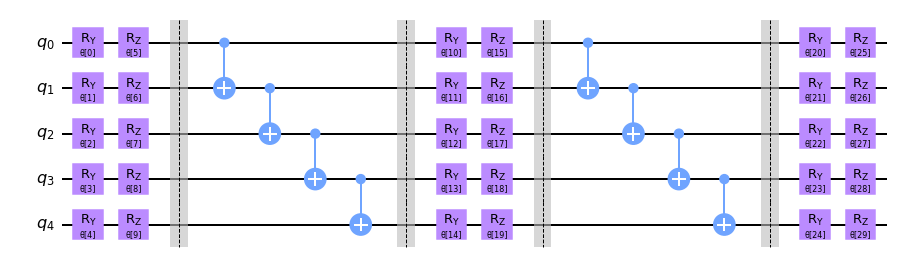

In [35]:
from qiskit.circuit.library import EfficientSU2

# (num_qubits=None, su2_gates=None, entanglement='full', reps=3, skip_unentangled_qubits=False, skip_final_rotation_layer=False, parameter_prefix='θ',
#    insert_barriers=False, initial_state=None, name='EfficientSU2')
EfficientSU2(5, entanglement='linear', reps=2, insert_barriers=True).decompose().draw(output="mpl")


### Remember that since we are dealing with machine learning, we also need to encode classical data into the quantum system (Lecture 3 - Data encoding)

#### **PauliFeatureMap**
Pauli rotations for encoding the data

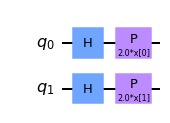

In [31]:
from qiskit.circuit.library import PauliFeatureMap

prep = PauliFeatureMap(2, reps=1, paulis=['Z'])
prep.decompose().draw(output="mpl")

#### **ZZFeatureMap**

IQP encoding (Lecture 3 data encoding) - Classically hard to simulate 

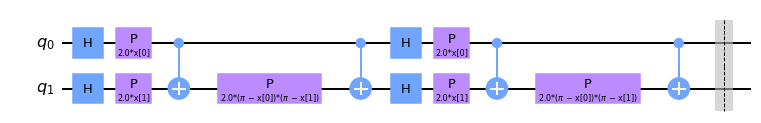

In [36]:
from qiskit.circuit.library import ZZFeatureMap, TwoLocal

encoding = ZZFeatureMap(feature_dimension=2, reps=2)
encoding.barrier()

encoding.decompose().draw(output="mpl")

### Compose encoding and ansatz

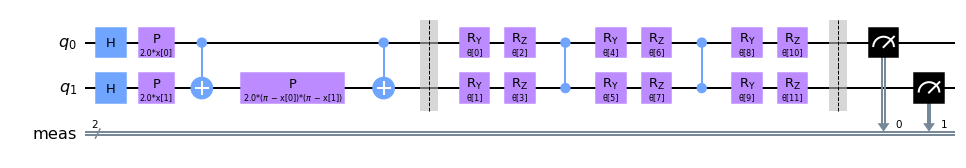

In [26]:
from qiskit.circuit.library import ZZFeatureMap, TwoLocal

encoding = ZZFeatureMap(feature_dimension=2, reps=1)
encoding.barrier()

ansatz = TwoLocal(2, ['ry', 'rz'], 'cz', reps=2)

qc = encoding.compose(ansatz)
full_circuit = Measurement(qc)

full_circuit.decompose().draw(output="mpl")

#### Assign parameters to the quantum circuit -> We need to bind both data and variational parameters --> We will need to call this function every time we execute the cost function to bind each parameter to the respective parameter in the circuit. This does not make much sense, but keep in mind that at every time step of the cost function i.e. as we iterate over the dataset to build the cost function, the encoding will change accordingly to each datapoint.

In [19]:
def circuit_parameters(encoding, ansatz, x, thetas, self_encoding=False):
    parameters = {}
    if self_encoding:
        for i, p in enumerate(list(encoding.parameters)):
            parameters[p] = x[i]
    else:
        for i, p in enumerate(list(encoding.ordered_parameters)):
            parameters[p] = x[i]
    for i, p in enumerate(ansatz.ordered_parameters):
        parameters[p] = thetas[i]
    return parameters

## 2. VQC building blocks - Measurement <a id="measurement"></a>

Types of measurement ? What is a valid output of the quantum circuit ?

It depends on the type of problem we have: 

    1) Binary classification 
    2) Multi class classification
    3) Multi label classification

    
<p align="center">
    <img width="600" height="300" src="images/classification_types_copy.jpeg">
</p>

#### 1) Binary classification <a id="binary"></a>

    1.1) Single-qubit expectation value estimation
    
<p align="center">
    <img width="600" height="150" src="images/single_qubit.jpeg">
</p>

    1.2) Multiple-qubit expectation value estimation

<p align="center">
    <img width="600" height="150" src="images/multi_qubit.jpeg">
</p>

    1.3) Parity function

For binary classification, the parity function is widely used. We measure all qubits and build the histogram. Then we build a new probability distribution over $\{0,1\}$ (binary classification) by measuring the #1's of each of the measured basis states. If #1's is even we add to label 0 the probability of that basis state, otherwise we add to label 1.

<p align="center">
    <img width="800" height="400" src="images/parity.jpeg">
</p>

#### Code for the parity function

In [21]:
def hamming_weight_parity(bitstring):
    hamming_weight = sum([int(k) for k in bitstring])
    return hamming_weight % 2
 

In [22]:
def parity_classification(counts, shots=1024):
    probs = np.zeros(2)
    for bitstring, counts in counts.items():
        hw_parity = hamming_weight_parity(bitstring)
        probs[hw_parity] += counts/shots
    
    return probs

##### But now we have to work with probabilities instead of an expectation value. Can't use the MSE loss function no more. <a id="cross-entropy"></a>

Yet another loss function - The **cross-entropy** loss or **log-loss**

Let's consider labels in **one-hot encoding** because it will be helpful in the multi class setting:

$$ y=0 \mapsto [1,0] $$
$$ y=1 \mapsto [0,1] $$

Our model now give predictions as a probability distribution over classes e.g. $\hat{y} = [p_0 , p_1]$

*"Cross-entropy loss, or log loss, measures the performance of a classification model whose output is a probability value between 0 and 1. Cross-entropy loss increases as the predicted probability diverges from the actual label. So predicting a probability of .012 when the actual observation label is 1 would be bad and result in a high loss value. A perfect model would have a log loss of 0".*

$$ L(y,\hat{y}) = -\sum_{i=0}^{C-1} y_i log \hat{y}_i$$

The loss will be zero when the actual predicted probability is 1.

#### Code for the cross-entropy loss and respective cost function that uses the parity function devised in the previous exercise

In [23]:
def cross_entropy_loss(y,y_hat):
    return np.sum(y*np.log(y_hat))

In [24]:
def cost_function(qc, encoding, ansatz, X, Y, thetas, self_encoding=False):
    #thetas -> variational parameters
    #X dataset
    #Y labels

    #build circuits for each datapoint
    circuits = [qc.assign_parameters(circuit_parameters(encoding, ansatz, x, thetas, self_encoding=self_encoding)) for x in X]

    backend = Aer.get_backend('qasm_simulator')
    results =  execute(circuits, backend).result()

    predictions = [parity_classification(results.get_counts(c)) for c in circuits]

    cost = -np.mean(np.array([cross_entropy_loss(y,y_hat) for (y,y_hat) in zip(Y, predictions)]))

    return cost

#### Keep in mind that there is a tradeoff between using a single qubit expectation value or measurement and multi-qubit expectation value or measurement. Namely, the **expressivity-trainability tradeoff**:
 
 <p align="center">
    <img width="650" height="500" src="images/barren_plateau.jpeg">
</p>

In randomly generated ansatze, if we have a global cost function, in general the gradient magnitude will decay exponentially with the depth of the circuit and the the number of qubits. We want highly expressive circuits, however, we can run into problems when training these circuits. 

    1.4) Probability of each basis state from the quantum circuit itself
 The probability of each basis state corresponds to the probability of each class
 
 <p align="center">
    <img width="600" height="150" src="images/probs.jpeg">
</p>

How to perform parameter-shift rules  ? 

Let $P_0$ be the zero state projector 

$$P_0 = | 0 \rangle \langle 0 | = \begin{pmatrix}
                                            1 0\\
                                            0 0 
                                    \end{pmatrix}$$

and $P_1$ the one state projector

$$P_1 = | 1 \rangle \langle 1 | = \begin{pmatrix}
                                            0 0\\
                                            0 1 
                                    \end{pmatrix}$$

Parameter-shift rules become: 

$$\partial_{\theta} |\langle 0 | \psi(s,\theta) \rangle|^2 = \frac{1}{2} \biggl[ \langle  \psi(s,\theta)| P_0 | \psi(s,\theta)\rangle_{\theta + \frac{\pi}{2}}  - \langle  \psi(s,\theta)| P_0 | \psi(s,\theta)\rangle_{\theta - \frac{\pi}{2}}\biggr]$$




#### 2) Multi-class classification <a id="mutli-class"></a>

In this problem we have $C$ classes. We usually work with one-hot encoding. Thus, in this setting it will correspond to a vector of $C$ entries. Remember that for the labels in supervised learning, this will correspond to a vector of zeros with a single one at the entry of class $i$. E.g. 
    $$ y = [0,1,0,0] $$

indicates class 2 out of 4 possible classes.
    
    2.1) Softmax activation function

Consider that we have a set of $C$ observables, one for representing each class. $O=\{O_0, \dots O_{C-1}\}$.

Suppose that the expectation value of each observable represent the output of the variational model for each class. 

$$ \langle O_c \rangle = \langle \psi(x,\theta)| O_{c} | \psi(x,\theta) \rangle$$

As in classical neural networks, we can use the softmax activation function to translate the continuous output of each expectation value in a probability distribution over classes as:

$$ P_c = \frac{e^{\langle O_c \rangle}}{\sum_{i=0}^{C-1} e^{\langle O_i \rangle} }$$

for class $c$. s.t $\sum_{c=0}^{C-1} P_c = 1$. The predictions of our model now are given by the vector:

$$ \hat{y} = [P_0, \dots , P_{C-1}] $$

These type of models are trained using the cross-entropy loss function introduced above.

$$ L(y,\hat{y}) = -\sum_{i=0}^{C-1} y_i log \hat{y}_i$$

    2.2) Probability of each basis state from the quantum circuit itself

Again, instead of using the softmax activation function in a set of $C$ observables, we can use a single observable and directly estimate the probability of each basis state corresponding to each class.

OR we could do a partition, for instance associate the probability of $c$ basis states to a given label

## 3. VQC for the ad_hoc dataset <a id="ad_hoc"></a>

Qiskit no longer has several datasets that you can use in your own projects. <href>[qiskit_machine_learning.datasets](https://qiskit.org/documentation/machine-learning/apidocs/qiskit_machine_learning.datasets.html)</href>

Scikit-learn has toy datasets as well - <href>[Scikit-learn datasets](https://scikit-learn.org/stable/datasets/toy_dataset.html)</href>

In [25]:
#import datasets from qiskit_machine_learning - DOES NOT WORK!!
from qiskit_machine_learning.datasets import ad_hoc_data, iris, wine, gaussian, digits, breast_cancer 

Let's work with the ad_hoc dataset. Each datapoint has only two features, which make it relatively simple to encode into a quantum circuit. 

In [26]:
train_data, train_labels, test_data, test_labels= (
    ad_hoc_data(training_size=20, test_size=5, n=2, gap=0.3, one_hot=False))

Visualize the data in 2D 

Text(0.5, 1.0, 'ad_hoc dataset')

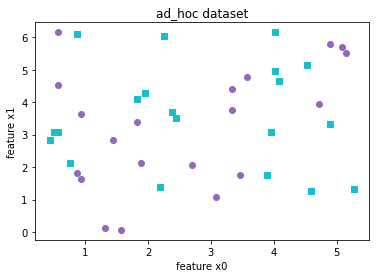

In [27]:
for feature, label in zip(train_data, train_labels):    
    if label:
        color = 'C4'
        marker = 'o'
        plt.scatter(feature[0], feature[1], color=color, marker=marker)
    else:
        color = 'C9'
        marker = 's'
        plt.scatter(feature[0], feature[1], color=color, marker=marker)

plt.xlabel("feature x0")
plt.ylabel("feature x1")
plt.title("ad_hoc dataset")

Let's first one-hot encode our labels. We can use the  <href>[sklearn library](https://scikit-learn.org/stable/) and use the OneHotEncoder. 

In [37]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
train_labels_oh = encoder.fit_transform(train_labels.reshape(-1, 1)).toarray()
test_labels_oh = encoder.fit_transform(test_labels.reshape(-1, 1)).toarray()

High order function for training

In [42]:
from qiskit.algorithms.optimizers import SPSA

def train(qc, encoding, ansatz, train_data, train_labels, self_encoding=False, lr=None, initial_point=None):
        # Callback function for optimiser for plotting purposes
        def store_intermediate_result(evaluation, parameter, cost, 
                                stepsize, accept):
                evaluations.append(evaluation)
                parameters.append(parameter)
                costs.append(cost)

        # Set up the optimization

        parameters = []
        costs = []
        evaluations = []

        if lr is not None:
                optimizer = SPSA(maxiter=100 , learning_rate=lr, callback=store_intermediate_result)
        else:
                optimizer = SPSA(maxiter=100, callback=store_intermediate_result)

        if initial_point is not None:
                initial_point = initial_point
        else:      
                initial_point = np.random.random(ansatz.num_parameters)

        objective_function = lambda variational: cost_function(qc,encoding, ansatz,
                train_data, train_labels, variational, self_encoding=self_encoding)

        # Run the optimization
        #opt_var, opt_value, _ = optimizer.optimize(len(initial_point), objective_function, initial_point=initial_point)
        res = optimizer.minimize(objective_function,initial_point)

        return res.x , res.fun , parameters, costs, evaluations 

Let's define the variational quantum model:

In [39]:
def Embedding(x=None, n_qubits=1):

    qc = QuantumCircuit(n_qubits,name="S")

    if x is not None:
        qc.rx(x[0],0)
        qc.rx(x[1],1)

    return qc

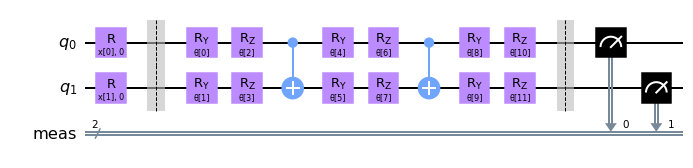

In [40]:
x = ParameterVector("x",2)

encoding = Embedding(x,n_qubits=2)
encoding.barrier()

ansatz = TwoLocal(2, ['ry', 'rz'], 'cx', reps=2)

qc = encoding.compose(ansatz)
qc.measure_all()

qc.decompose().draw(output="mpl")

In [43]:
opt_var, opt_value , parameters, costs, evaluations = train(qc, encoding, ansatz, train_data, train_labels_oh, self_encoding=True)

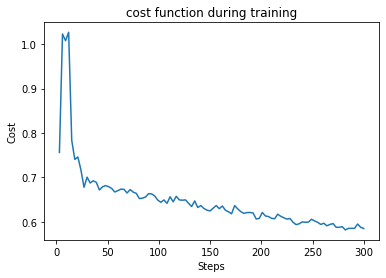

In [44]:
fig = plt.figure()
plt.plot(evaluations, costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.title("cost function during training")
plt.show()

In [45]:
def accuracy(data, labels, thetas, self_encoding=False):
    circuits = [qc.assign_parameters(circuit_parameters(encoding, ansatz, x, thetas, self_encoding=self_encoding)) for x in data]

    backend = Aer.get_backend('qasm_simulator')
    results =  execute(circuits, backend).result()

    probs = [parity_classification(results.get_counts(c)) for c in circuits]

    prediction = [0 if p[0] > p[1] else 1 for p in probs]
    accuracy = 0
    for i, p in enumerate(prediction):
        if (p and labels[i]) or (not p and not labels[i]):
            accuracy += 1
    accuracy /= len(labels)
    return accuracy, prediction

In [46]:
accuracy, prediction = accuracy(test_data, test_labels, opt_var, self_encoding=True)
print("Test set accuracy - {}".format(accuracy))

Test set accuracy - 0.7


#### How can we increase the accuracy in test data? 
* Perhaps we can make the encoding more expressive

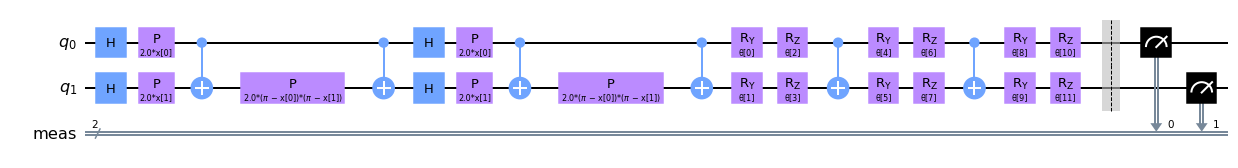

In [47]:
encoding = ZZFeatureMap(feature_dimension=2, reps=2)
ansatz = TwoLocal(2, ['ry', 'rz'], 'cx', reps=2)

qc = encoding.compose(ansatz)
qc.measure_all()
qc.decompose().draw(output="mpl")

In [28]:
opt_var, opt_value , parameters, costs, evaluations = train(qc, encoding, ansatz, train_data, train_labels_oh)

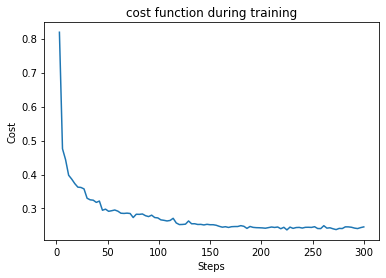

In [29]:
fig = plt.figure()
plt.plot(evaluations, costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.title("cost function during training")
plt.show()

In [32]:
accuracy, prediction = accuracy(test_data, test_labels, opt_var)
print("Test set accuray - {}".format(accuracy))

Test set accuray - 0.9


#### Qiskit has already a VQC high order function, we just need to pass the loss function, and corresponding training data

Take a look at <href>[qiskit_machine_learning.algorithms.classifiers](https://github.com/Qiskit/qiskit-machine-learning/blob/main/qiskit_machine_learning/algorithms/classifiers/vqc.py)</href> 

In [48]:
from qiskit_machine_learning.algorithms.classifiers import VQC

def store_intermediate_result(evaluation, parameter, cost, 
                                stepsize, accept):
                evaluations.append(evaluation)
                parameters.append(parameter)
                costs.append(cost)

        # Set up the optimization

parameters = []
costs = []
evaluations = []
initial_point = np.random.random(ansatz.num_parameters)

vqc = VQC(feature_map=encoding,
          ansatz=ansatz,
          loss='cross_entropy',
          optimizer=SPSA(callback=store_intermediate_result),
          initial_point=initial_point,
          quantum_instance=Aer.get_backend('qasm_simulator'))

vqc.fit(train_data, train_labels_oh)

/var/folders/n9/tdqdt7991733xw39nzh49y600000gn/T/ipykernel_10091/1977239094.py:16: DeprecationWarning: The quantum_instance argument is deprecated as of version 0.5.0 and will be removed no sooner than 3 months after the release. Instead use the sampler argument.
  vqc = VQC(feature_map=encoding,


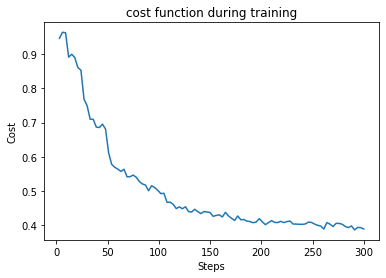

In [49]:
fig = plt.figure()
plt.plot(evaluations, costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.title("cost function during training")
plt.show()

In [50]:
vqc.score(test_data, test_labels_oh)

0.8